
Reading CSV...
338 molecules | actives: 219


  0%|          | 0/338 [00:00<?, ?it/s]

[I 2025-06-25 16:54:02,886] A new study created in memory with name: no-name-79a1aead-e80b-453b-87fa-f6bf58dc8a5f


Feature matrix: (338, 1050)
scale_pos_weight = 0.54


  0%|          | 0/15 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	valid_0's auc: 0.72822
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[5]	valid_0's auc: 0.652936
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[73]	valid_0's auc: 0.85322
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[246]	valid_0's auc: 0.767519
Training until validation scores don't improve for 100 rounds
Ea

Bit,Gain %,Fragment
147,7.09,
361,5.94,
301,5.22,
255,1.80,
33,1.64,
926,1.42,
881,1.36,
80,1.36,
128,1.33,
667,1.31,

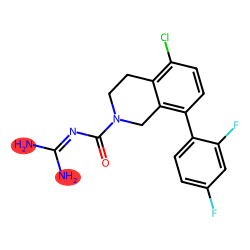
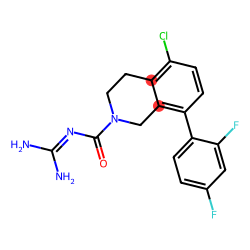
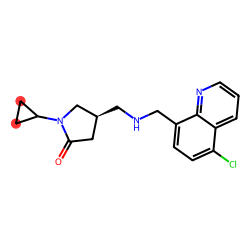
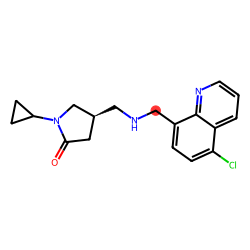
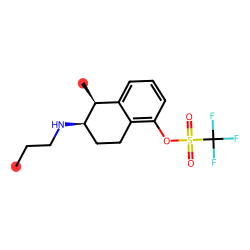
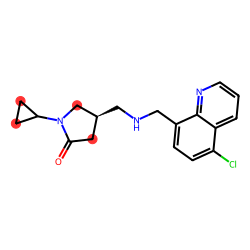
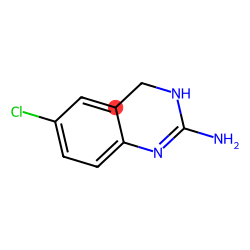
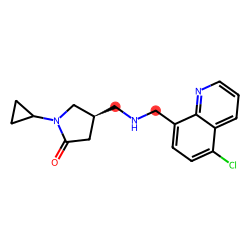
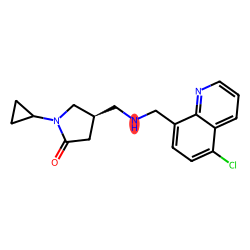
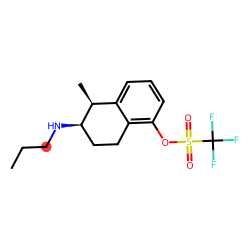
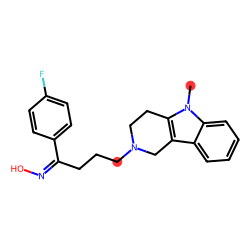
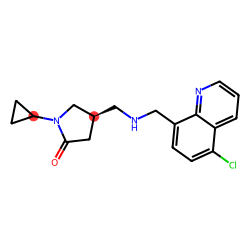
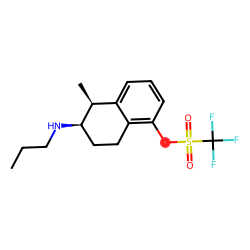

Saved HTML table of top bits
Saved model to disk


In [ ]:
# =============================================================
#Generic activity classification pipeline using LightGBM and RDKit for 5HT_ target receptor
# --------------------------------------------------------------
#  auto class balance
#  mean ROC/PR + CM 
#  top-30 features to CSV
#  all resultes saved per receptor
# =============================================================


import os, random, joblib, warnings
from pathlib import Path
from io import BytesIO
import numpy as np; np.set_printoptions(suppress=True)
import pandas as pd
from tqdm.auto import tqdm

# Ensuring reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
warnings.filterwarnings('ignore')

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors, Crippen, rdMolDescriptors
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
import optuna
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Global matplotlib style
plt.rcParams.update({
    'font.size': 10,
    'legend.fontsize': 9,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 8,    
    'ytick.labelsize': 8,   
    'legend.frameon': True,
    'legend.edgecolor': 'gray',
    'legend.facecolor': 'white'
})

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, matthews_corrcoef, f1_score,
    precision_score, recall_score, confusion_matrix,
    roc_curve, precision_recall_curve
)

# === 1. PARAMETERS ===
CSV_PATH    = '../Cleaned_data/cleaned_5HT5A.csv' # pathname
KI_COLUMN   = 'Standard Value'
SMI_COLUMN  = 'Smiles'
RECEPTOR    = Path(CSV_PATH).stem
OUT_DIR     = Path('results')/RECEPTOR; OUT_DIR.mkdir(parents=True, exist_ok=True)
ACTIVE_TH   = 1000
FP_RADIUS   = 2
N_BITS      = 1024
N_FOLDS     = 5
N_TRIALS    = 15
BOOST_ROUNDS= 600
EARLY_STOP  = 100

DESC_NAMES = [
    'MolWt','LogP','MolMR','HBA','HBD','RotB','RingCt','Fsp3','TPSA',
    'AliRings','AroRings','SatRings','AliCarb','AroCarb','SatCarb',
    'AliHet','AroHet','SatHet','Hetero','Amide','FormalChg',
    'ExactWt','Stereo','StereoUnsp','ValEl','LabuteASA'
]
DESC_SLICE = slice(N_BITS, N_BITS+len(DESC_NAMES))

# === 2. DATA LOADING AND FILTERING ===
print('\nReading CSV...')
df = (pd.read_csv(CSV_PATH)
      .dropna(subset=[SMI_COLUMN, KI_COLUMN])
      .drop_duplicates(subset=SMI_COLUMN))
df['Active'] = (df[KI_COLUMN] < ACTIVE_TH).astype(int)
print(f"{len(df):,} molecules | actives: {df['Active'].sum()}")

# === 3. FEATURISATION ===
def ecfp(m):
    fp = AllChem.GetMorganFingerprintAsBitVect(m, FP_RADIUS, N_BITS)
    arr = np.zeros((N_BITS,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

def physchem(m):
    return np.array([
        Descriptors.MolWt(m), Descriptors.MolLogP(m), Crippen.MolMR(m),
        Descriptors.NumHAcceptors(m), Descriptors.NumHDonors(m),
        Descriptors.NumRotatableBonds(m), Descriptors.RingCount(m),
        Descriptors.FractionCSP3(m), rdMolDescriptors.CalcTPSA(m),
        rdMolDescriptors.CalcNumAliphaticRings(m), rdMolDescriptors.CalcNumAromaticRings(m),
        rdMolDescriptors.CalcNumSaturatedRings(m), rdMolDescriptors.CalcNumAliphaticCarbocycles(m),
        rdMolDescriptors.CalcNumAromaticCarbocycles(m), rdMolDescriptors.CalcNumSaturatedCarbocycles(m),
        rdMolDescriptors.CalcNumAliphaticHeterocycles(m), rdMolDescriptors.CalcNumAromaticHeterocycles(m),
        rdMolDescriptors.CalcNumSaturatedHeterocycles(m), rdMolDescriptors.CalcNumHeteroatoms(m),
        rdMolDescriptors.CalcNumAmideBonds(m), float(Chem.GetFormalCharge(m)),
        rdMolDescriptors.CalcExactMolWt(m), rdMolDescriptors.CalcNumAtomStereoCenters(m),
        rdMolDescriptors.CalcNumUnspecifiedAtomStereoCenters(m), Descriptors.NumValenceElectrons(m),
        rdMolDescriptors.CalcLabuteASA(m)
    ], dtype=np.float32)

fps, descs, labels = [], [], []
mols, bit_infos = [], []
for smi, lab in tqdm(zip(df[SMI_COLUMN], df['Active']), total=len(df)):
    m = Chem.MolFromSmiles(smi)
    if m is None:
        continue
    info = {}
    fp = AllChem.GetMorganFingerprintAsBitVect(m, FP_RADIUS, nBits=N_BITS, bitInfo=info)
    arr = np.zeros((N_BITS,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    fps.append(arr)
    descs.append(physchem(m))
    labels.append(lab)
    mols.append(m)
    bit_infos.append(info)

X_fp = np.vstack(fps).astype(np.uint8)
X_ds = np.vstack(descs).astype(np.float32)
X_all = np.hstack([X_fp, X_ds]); y = np.array(labels, int)
print('Feature matrix:', X_all.shape)

# === 4. CLASS BALANCE ===
pos_weight = (y==0).sum()/(y==1).sum()
print(f'scale_pos_weight = {pos_weight:.2f}')

# === 5. OPTUNA HYPERPARAMETER TUNING ===
def objective(trial):
    params = {
        'objective':'binary','metric':'auc','verbosity':-1,'seed':SEED,
        'boosting_type':'gbdt','scale_pos_weight':pos_weight,
        'learning_rate':trial.suggest_float('lr',0.01,0.3,log=True),
        'num_leaves':trial.suggest_int('leaves',31,256,8),
        'max_depth':trial.suggest_int('depth',3,12),
        'min_data_in_leaf':trial.suggest_int('min_data',10,100),
        'feature_fraction':trial.suggest_float('f_frac',0.6,1.0),
        'bagging_fraction':trial.suggest_float('b_frac',0.6,1.0),'bagging_freq':1,
        'lambda_l1':trial.suggest_float('l1',0,5),'lambda_l2':trial.suggest_float('l2',0,5)
    }
    cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
    aucs=[]
    for tr, te in cv.split(X_all, y):
        scaler = StandardScaler().fit(X_all[tr, DESC_SLICE])
        Xtr = X_all[tr].copy(); Xtr[:,DESC_SLICE]=scaler.transform(Xtr[:,DESC_SLICE])
        Xte = X_all[te].copy(); Xte[:,DESC_SLICE]=scaler.transform(Xte[:,DESC_SLICE])
        mdl = lgb.train(params, lgb.Dataset(Xtr,y[tr]), BOOST_ROUNDS,
                        valid_sets=[lgb.Dataset(Xte,y[te])],
                        callbacks=[early_stopping(EARLY_STOP), log_evaluation(False)])
        aucs.append(roc_auc_score(y[te], mdl.predict(Xte)))
    return np.mean(aucs)

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED),
                            pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective, n_trials=N_TRIALS, n_jobs=-1, show_progress_bar=True)
BEST_PARAMS = study.best_params | {'objective':'binary','metric':'auc','verbosity':-1,
                                   'seed':SEED,'boosting_type':'gbdt','scale_pos_weight':pos_weight}
print(f"Best CV AUC: {study.best_value:.3f}")

# === 6. CROSS-VALIDATION METRICS ===
kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
scores = {m:[] for m in ('roc_auc','mcc','f1','precision','recall')}
cm_total = np.zeros((2,2),int)
roc_curves, pr_curves = [], []
print('Cross-validating...')
for tr, te in kf.split(X_all, y):
    scaler = StandardScaler().fit(X_all[tr, DESC_SLICE])
    Xtr = X_all[tr].copy(); Xtr[:,DESC_SLICE]=scaler.transform(Xtr[:,DESC_SLICE])
    Xte = X_all[te].copy(); Xte[:,DESC_SLICE]=scaler.transform(Xte[:,DESC_SLICE])
    mdl = lgb.train(BEST_PARAMS, lgb.Dataset(Xtr,y[tr]), BOOST_ROUNDS,
                    valid_sets=[lgb.Dataset(Xte,y[te])],
                    callbacks=[early_stopping(EARLY_STOP), log_evaluation(False)])
    proba = mdl.predict(Xte); pred = (proba>=0.5).astype(int)
    scores['roc_auc'].append(roc_auc_score(y[te],proba))
    scores['mcc'].append(matthews_corrcoef(y[te],pred))
    scores['f1'].append(f1_score(y[te],pred))
    scores['precision'].append(precision_score(y[te],pred))
    scores['recall'].append(recall_score(y[te],pred))
    cm_total += confusion_matrix(y[te], pred, labels=[0,1])
    fpr,tpr,_ = roc_curve(y[te], proba)
    precision, recall, _ = precision_recall_curve(y[te], proba)
    roc_curves.append((fpr,tpr))
    pr_curves.append((recall, precision))
for m, arr in scores.items(): print(f"{m}: {np.mean(arr):.3f} ± {np.std(arr):.3f}")

# === 7. SAVE CONFUSION MATRIX ===
color_mask = np.array([[1,0],[0,1]])
cmap = ListedColormap(['#FFCDD2','#B9F6CA'])
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(color_mask, cmap=cmap)
for i in range(2):
    for j in range(2): ax.text(j,i,cm_total[i,j],ha='center',va='center',fontsize=13, fontweight='bold')
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xlabel('Predicted'); ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.tight_layout(); fig.savefig(OUT_DIR/'confusion_matrix.png',dpi=300); plt.close(fig)
print('Saved confusion_matrix.png')

# === 8. SAVE ROC & PR CURVES ===
mean_fpr = np.linspace(0,1,101)
tprs = [np.interp(mean_fpr, fpr, tpr) for fpr,tpr in roc_curves]
mean_tpr, std_tpr = np.mean(tprs,0), np.std(tprs,0)
fig, ax = plt.subplots(figsize=(4.5,4))
ax.plot(mean_fpr, mean_tpr, lw=2, label='mean ROC')
ax.fill_between(mean_fpr, np.maximum(mean_tpr-std_tpr,0), np.minimum(mean_tpr+std_tpr,1), alpha=0.25)
ax.plot([0,1],[0,1],'--',lw=1, label='random')
ax.set_xlabel('FPR'); ax.set_ylabel('TPR'); ax.set_title('ROC (mean ± 1σ)'); ax.legend()
plt.tight_layout(); fig.savefig(OUT_DIR/'roc_curve_mean.png',dpi=300); plt.close(fig)

mean_rec = np.linspace(0,1,101)
precs = np.vstack([np.interp(mean_rec, rec[::-1], prec[::-1]) for rec, prec in pr_curves])
mean_prec, std_prec = precs.mean(0), precs.std(0)
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(mean_rec, mean_prec, lw=2, label='mean PR')
ax.fill_between(mean_rec, np.maximum(mean_prec-std_prec,0), np.minimum(mean_prec+std_prec,1), alpha=0.2)
ax.set_xlabel('Recall'); ax.set_ylabel('Precision'); ax.set_title('PR Curve'); ax.legend()
plt.tight_layout(); fig.savefig(OUT_DIR/'pr_curve_mean.png',dpi=300); plt.close(fig)
print('Saved ROC and PR curves')

# === 9. FINAL MODEL ===
scaler_full = StandardScaler().fit(X_all[:, DESC_SLICE])
X_all_scaled = X_all.copy(); X_all_scaled[:,DESC_SLICE]=scaler_full.transform(X_all_scaled[:,DESC_SLICE])
final_lgb = lgb.train(BEST_PARAMS, lgb.Dataset(X_all_scaled,y), num_boost_round=int(mdl.best_iteration*1.1))

# === 10. FEATURE IMPORTANCE ===
feat_names = [f'Bit_{i}' for i in range(N_BITS)] + DESC_NAMES
gain = final_lgb.feature_importance(importance_type='gain')
top_idx = np.argsort(gain)[::-1][:30]
top_df = pd.DataFrame({'Feature':[feat_names[i] for i in top_idx],'Gain_%':100*gain[top_idx]/gain.sum()}).round(2)
top_df.to_csv(OUT_DIR/'top_features.csv', index=False)
print('Saved feature importance to CSV')

# === 11. BIT FRAGMENTS VISUALIZATION ===
def draw_bit(mol, binfo, bit_id, r=FP_RADIUS):
    atoms = [a for a, rad in binfo[bit_id] if rad <= r]
    return Draw.MolToImage(mol,
                           highlightAtoms=atoms,
                           highlightColor=(1.0, 0.2, 0.2),
                           size=(250, 250))

from rdkit.Chem import Draw
from IPython.display import display, HTML
import base64

bits_df = top_df[top_df['Feature'].str.startswith('Bit_')].reset_index(drop=True)
html = "<h3>Top fingerprint bits</h3><table><tr><th>Bit</th><th>Gain %</th><th>Fragment</th></tr>"
for _, row in bits_df.iterrows():
    bit_id = int(row['Feature'].split('_')[1])
    gain = row['Gain_%']
    img = None
    for mol, binfo in zip(mols, bit_infos):
        if bit_id in binfo:
            img = draw_bit(mol, binfo, bit_id)
            break
    if img:
        buf = BytesIO(); img.save(buf, format='PNG')
        b64 = base64.b64encode(buf.getvalue()).decode()
        html += f"<tr><td>{bit_id}</td><td>{gain:.2f}</td><td><img src='data:image/png;base64,{b64}'/></td></tr>"
html += "</table>"
display(HTML(html))
with open(OUT_DIR/'top_bits_fragments.html', 'w', encoding='utf-8') as f:
    f.write(html)
print('Saved HTML table of top bits')

# === 12. SAVE MODEL ===
os.makedirs('models', exist_ok=True)
pkg = {'model':final_lgb,'scaler':scaler_full,'desc_slice':DESC_SLICE,'desc_cols':DESC_NAMES,'bit_size':N_BITS,'params':BEST_PARAMS}
joblib.dump(pkg, f'models/LGBM_ECFP4_RDKit_{RECEPTOR}.pkl')
print('Saved model to disk')